<a href="https://colab.research.google.com/github/mingyuema1217/multilabel-image-multi-classfication-/blob/main/Multi_classification_for_multi_label_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library and Setup Environment

In [ ]:
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached 

In [ ]:
import os
import re
import time
import random
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO
from PIL import Image
from sklearn.metrics import f1_score
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.utils import resample
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler, random_split
from transformers import AutoTokenizer, AutoModel, AutoConfig, BertTokenizer, BertModel, BertConfig, BertForSequenceClassification, AdamW
from efficientnet_pytorch import EfficientNet
from torchvision.models import mobilenet_v2

In [ ]:
# Set the seed for Python's built-in random library
random.seed(42)

# Set the seed for NumPy's random generator
np.random.seed(42)

# Set the seed for PyTorch
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    # Set the seed for all GPUs
    torch.cuda.manual_seed_all(42)

## Setup For GPU

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
torch.cuda.is_available()

True

## Setup For File Path

In [ ]:
# Here is the path of dataset
dir_location = "/kaggle/input/multi-label-classification-competition-2024/"

# Download the Data From

This is the API that directly inputs the data from Kaggle. If loading fails due to "Failed to load (likely expired)", follow these steps:


1. Go to Kaggle and find the competition: multi-label-classification-competition-2024.
2. Click on "Submit Prediction".
3. Choose "Create a Notebook" for the competition.
4. Select "Open in Colab".

There will be a block of code similar to the following, containing the unexpired Kaggle dataset that can be loaded.

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'multi-label-classification-competition-2024:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F74788%2F8176112%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240515%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240515T132342Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D074da1a90f4800a89d19daa650a9890f2a3c4ae641ddc8c7202a1960578cc5991974fb595b699fdbbda707cea4ff18649ffde8fe8f142c1948ef4cf22fad51de70c9b42d91819e4b524a0268e1dcf57fc31a73e1c1aafea2593c3833583734e9eeee789a89461eb6216566d90cc9c937e67a1269e2909b5851840bf766ab1287419efef16c21d9987ebd7671c4fcb9ac81761bdae6d9022dd164e13277c345dc52feb553bbd66929880b983805f9a5172f0f70bf266a2f82a5199867e82f360c00aa451faead37a88bb72cecadb405f15aa817bf6e8124556ff163099d1fe870f3a8b266a930df062de31e950451b0cb30da069629d0a3528383c80e9f03938c'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

[==================================================] 418142402 bytes downloaded
Downloaded and uncompressed: multi-label-classification-competition-2024
Data source import complete.


# EDA

In [ ]:
# Check the dataset in train.csv
FILENAME = f'{dir_location}/COMP5329S1A2Dataset/train.csv'
with open(FILENAME) as file:
    lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]
train = pd.read_csv(StringIO(''.join(lines)), escapechar="/")
train.head()

,ImageID,Labels,Caption
0,0.jpg,1,Woman in swim suit holding parasol on sunny day.
1,1.jpg,1 19,A couple of men riding horses on top of a gree...
2,2.jpg,1,They are brave for riding in the jungle on tho...
3,3.jpg,8 3 13,a black and silver clock tower at an intersect...
4,4.jpg,8 3 7,A train coming to a stop on the tracks out side.


In [ ]:
train.describe()

,ImageID,Labels,Caption
count,29996,29996,29996
unique,29996,776,29232
top,0.jpg,1,A man flying through the air while riding a sk...
freq,1,14074,33


In [ ]:
train_images = train['ImageID'].values
train_captions = train['Caption'].values
train_labels = train['Labels'].values

# Folder containing the images
data_folder = f'{dir_location}COMP5329S1A2Dataset/data'
# List to store the paths of the training images
train_images_location = []

# Construct the paths for the training images
for image_id in train_images:
    image_path = os.path.join(data_folder, image_id)
    train_images_location.append(image_path)

# Display the first few image locations
print(f"Example of train images' location: {train_images_location[:5]}")
print(f"Example of train captions: {train_captions[:5]}")
print(f"Example of train labels: {train_labels[:5]}")

Example of train images' location: ['/kaggle/input/multi-label-classification-competition-2024/COMP5329S1A2Dataset/data/0.jpg', '/kaggle/input/multi-label-classification-competition-2024/COMP5329S1A2Dataset/data/1.jpg', '/kaggle/input/multi-label-classification-competition-2024/COMP5329S1A2Dataset/data/2.jpg', '/kaggle/input/multi-label-classification-competition-2024/COMP5329S1A2Dataset/data/3.jpg', '/kaggle/input/multi-label-classification-competition-2024/COMP5329S1A2Dataset/data/4.jpg']
Example of train captions: ['Woman in swim suit holding parasol on sunny day.'
 'A couple of men riding horses on top of a green field.'
 'They are brave for riding in the jungle on those elephants.'
 'a black and silver clock tower at an intersection near a tree'
 'A train coming to a stop on the tracks out side.']
Example of train labels: ['1' '1 19' '1' '8 3 13' '8 3 7']


In [ ]:
FILENAME = f'{dir_location}COMP5329S1A2Dataset/test.csv'
with open(FILENAME) as file:
    lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]
test = pd.read_csv(StringIO(''.join(lines)), escapechar="/")
test.head()

,ImageID,Caption
0,30000.jpg,A little girl waring a krispy kreme hat holdin...
1,30001.jpg,A beautiful young woman holding an orange fris...
2,30002.jpg,A group of people sitting on couch next to a c...
3,30003.jpg,A person on a snowboard rides on the hill.
4,30004.jpg,A man riding a skateboard with a helmet on in ...


EDA

In [ ]:
# Get the shape of images
print('Train', train_images.shape, train_labels.shape)

Train (29996,) (29996,)


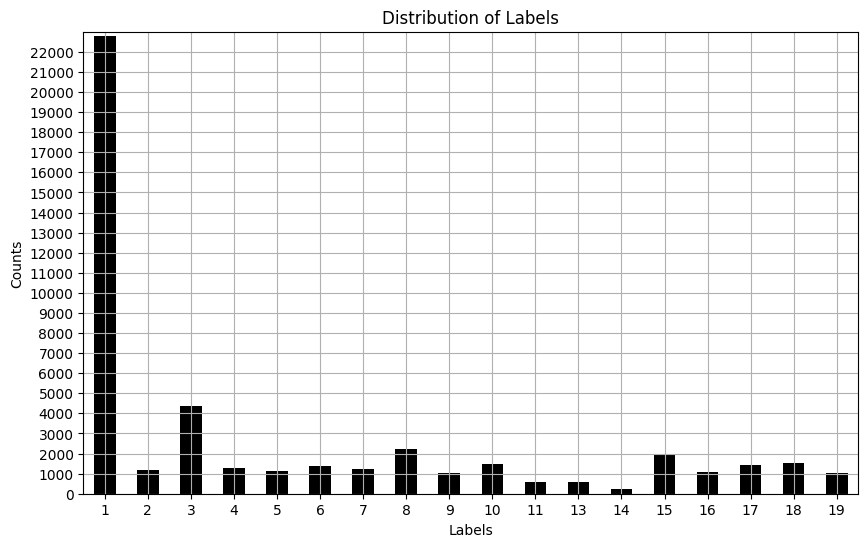

In [ ]:
# Split the multi-labels and count their occurrences
labels = train['Labels'].str.split().explode()
labels = labels.astype(int)
counts = labels.value_counts().sort_index()
# Plot the distribution of labels
counts.plot(kind='bar', figsize=(10, 6), color='black')
plt.title('Distribution of Labels')
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.ylim((0,23000))
plt.grid()
plt.yticks(np.arange(0,23000,1000))
plt.xticks(rotation=0)
plt.show()

In [ ]:
# Print the count of each label
print(counts)

Labels
1     22794
2      1162
3      4364
4      1272
5      1130
6      1394
7      1221
8      2210
9      1042
10     1471
11      604
13      605
14      251
15     1934
16     1099
17     1430
18     1525
19     1020
Name: count, dtype: int64


# Preprocess

## Build Dataset

In [ ]:
class MyDataset(Dataset):
    def __init__(self, mode="train", transform=None):
        """Initialize the dataset with specific mode and transformations.

        Args:
            mode (str): Dataset mode ('train' or 'test').
            transform: PyTorch transforms to apply to the images.
        """
        self.mode = mode
        self.transform = transform

        # Define file path
        file_location = f'{dir_location}/COMP5329S1A2Dataset'
        self.file_name = f'{file_location}/{self.mode}.csv'

        # Read file from path，handle qutation marks
        with open(self.file_name, 'r') as file:
            lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]
            self.df = pd.read_csv(StringIO(''.join(lines)), escapechar="/")
            self.mlb = MultiLabelBinarizer()

        # Define images, image_id, captions and labels
        if mode == "train":
            # Convert label strings to lists and adjust split method based on your data
            self.df['Labels'] = self.df['Labels'].apply(lambda x: x.split(' '))
            self.labels = list(self.df['Labels'])
            # Apply one hot for label
            self.labels = self.mlb.fit_transform(self.labels)
            # Save this mlb setting
            joblib.dump(self.mlb, 'mlb.pkl')
        self.images = [os.path.join(f'{file_location}/data', fname) for fname in self.df['ImageID']]
        self.img_ids = list(self.df['ImageID'])
        self.captions = list(self.df['Caption'])

    def __getitem__(self, index):
        # Load images
        image_path = self.images[index]
        image = Image.open(image_path).convert('RGB')

        # Get the caption and ids
        caption = self.captions[index]
        img_id = self.img_ids[index]

        # Transform the image
        if self.transform:
            image = self.transform(image)
        # Only train dataset has label
        if self.mode == 'train':
            label = self.labels[index]
            input_sample = image, img_id, caption, label
        else:
            input_sample = image, img_id, caption

        return input_sample

    def __len__(self):
        return len(self.captions)


In [ ]:
# Define the Transformation methods
transformations = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        # Transfer image to tensor
        transforms.ToTensor(),
    ])

In [ ]:
# Define the instance of MyDataset
dataset = MyDataset('train', transformations)

In [ ]:
# Check if the dataset can get the data correctly
dataset[4]

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 '4.jpg',
 'A train coming to a stop on the tracks out side.',
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0]))

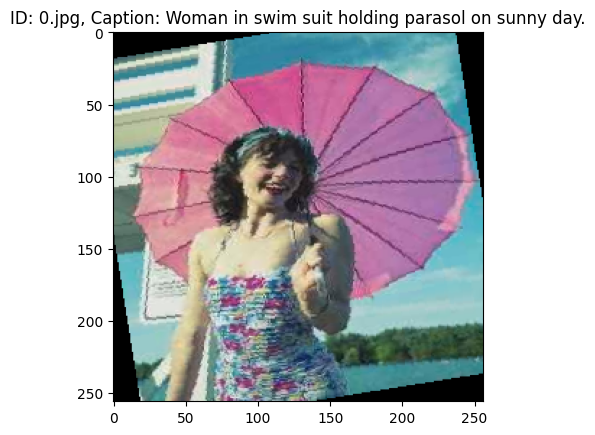

In [ ]:
image_tensor, img_id, caption, label = dataset[0]
# Change from tensor to image to display the image
image = transforms.ToPILImage()(image_tensor)

# Display the image
plt.imshow(image)
plt.title(f'ID: {img_id}, Caption: {caption}')
plt.show()

## Split the data and get Validation set and Training Set

In [ ]:
# Set the size for validation and train dataset
total_size = len(dataset)
train_size = int(total_size * 0.8)
val_size = total_size - train_size

# Split and create train dataset and validation dataset
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

## Define the loader function for train, val, test

In [ ]:
# Set the default batch size to 64
def get_train_val_loader(batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader

In [ ]:
# Create dataloader for test set
def get_test_loader(batch_size):
    test_dataset = MyDataset('test', transformations)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return test_loader

# Training and Test Methods

## Helper Function

In [ ]:
def get_model_size(model):
    # Save the entire model
    torch.save(model, 'model_entire01.pth')

    # Save only the state dictionary
    torch.save(model.state_dict(), 'model_state_dict.pth')

    size_entire = os.path.getsize('model_entire01.pth')
    print(f"Size of the entire model: {size_entire / 1024**2:.2f} MB")

In [ ]:
def plot_training_results(train_losses, valid_losses, train_f1_scores, valid_f1_scores):
    plt.figure(figsize=(10, 5))

    # Plot training and validation losses
    plt.plot(train_losses, 'r-', label='Train Loss')
    plt.plot(valid_losses, 'r--', label='Validation Loss')

    # Plot training and validation F1 scores
    plt.plot(train_f1_scores, 'b-', label='Train F1 Score')
    plt.plot(valid_f1_scores, 'b--', label='Validation F1 Score')

    plt.title('Training and Validation Losses & F1 Scores')
    plt.xlabel('Epochs')
    plt.ylabel('Metrics')
    plt.legend()
    plt.show()

## Image Only

In [ ]:
def train_model(model, optimizer, loss_function, train_loader, epoch):
    train_losses = []
    train_f1_scores = []
    # Set the model to training mode
    model.train()
    train_loss = 0.0
    all_train_labels = []
    all_train_preds = []
    train_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1} Training")
    start_time = time.time()

    for images, _, _, labels in train_tqdm:
        # Put image and labels to gpu for accelerate
        images, labels = images.to(device), labels.to(device).float()
        # Clear gradients for this training step
        optimizer.zero_grad()
        # Forward pass
        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        # Binary prediction thresholding
        predicted = torch.sigmoid(outputs).detach() > 0.5
        all_train_labels.extend(labels.cpu().tolist())
        all_train_preds.extend(predicted.cpu().tolist())

    epoch_time = time.time() - start_time
    train_losses.append(train_loss / len(train_loader))
    train_f1_score = f1_score(all_train_labels, all_train_preds, average='micro')
    train_f1_scores.append(train_f1_score)

    print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]}, Train F1 Score: {train_f1_scores[-1]}, Epoch Time: {epoch_time:.2f} seconds')
    return train_losses, train_f1_scores

In [ ]:
def validate_model(model, val_loader, loss_function, epoch):
    valid_losses = []
    valid_f1_scores = []
    # Set the model to evaluation mode
    model.eval()
    valid_loss = 0.0
    all_valid_labels = []
    all_valid_preds = []
    valid_tqdm = tqdm(val_loader, desc=f"Epoch {epoch+1} Validation")
    start_time = time.time()

    # Disable gradient computation
    with torch.no_grad():
        for images, _, _, labels in valid_tqdm:
            #set image and labels to GPU
            images, labels = images.to(device), labels.to(device).float()
            # Forward pass only for image
            outputs = model(images)
            loss = loss_function(outputs, labels)
            valid_loss += loss.item()
            # Binary prediction thresholding
            predicted = torch.sigmoid(outputs).detach() > 0.5
            all_valid_labels.extend(labels.cpu().tolist())
            all_valid_preds.extend(predicted.cpu().tolist())

    valid_time = time.time() - start_time
    valid_losses.append(valid_loss / len(val_loader))
    valid_f1_score = f1_score(all_valid_labels, all_valid_preds, average='micro')
    valid_f1_scores.append(valid_f1_score)

    print(f'Epoch {epoch+1}, Validation Loss: {valid_losses[-1]}, Validation F1 Score: {valid_f1_scores[-1]}, Validation Time: {valid_time:.2f} seconds')
    return valid_losses, valid_f1_scores

In [ ]:
def predict_model(model, test_loader):
    model.eval()
    predictions = []
    image_ids = []
    predict_tqdm = tqdm(test_loader, desc='Predicting')
    start_time = time.time()

    with torch.no_grad():
        for images, ids, captions in predict_tqdm:
            images = images.to(device)
            outputs = model(images)
            # Binary prediction thresholding
            predicted = torch.sigmoid(outputs).detach() > 0.5
            predictions.extend(predicted.cpu().numpy().tolist())
            image_ids.extend(ids)

    predict_time = time.time() - start_time
    print(f'Predict Time: {predict_time:.2f} seconds')

    # Load the mlb and convert predictions
    mlb = joblib.load('mlb.pkl')
    predictions_array = np.array(predictions)
    predicted_labels = mlb.inverse_transform(predictions_array)

    # Join all labels together
    labels_str = [' '.join(labels) for labels in predicted_labels]

    # Prepare DataFrame
    results = pd.DataFrame({
        'ImageID': image_ids,
        'Labels': labels_str
    })

    # Generate a file name with model name
    # Get the model's class name as a string
    model_name = type(model).__name__
    results.to_csv(f'result_{model_name}.csv', index=False)

    return results

## Text Only

In [ ]:
def text_train_model(model, optimizer, loss_function, train_loader, epoch):
    train_losses = []
    train_f1_scores = []
    model.train()
    train_loss = 0.0
    all_train_labels = []
    all_train_preds = []
    train_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1} Training")
    start_time = time.time()

    for _, img_ids, captions, labels in train_tqdm:
        labels = labels.to(device).float()
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        # Tokenize captions
        encoded_inputs = tokenizer(captions, padding=True, truncation=True, max_length=128, return_tensors="pt")
        # Move tokenized ids to device
        input_ids = encoded_inputs['input_ids'].to(device)
        # Move attention masks to device
        attention_mask = encoded_inputs['attention_mask'].to(device)

        # Forward pass with tokenized input and attention mask
        outputs = model(input_ids, attention_mask)
        # Compute loss
        loss = loss_function(outputs, labels)
        # Clear gradients for this training step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        predicted = torch.sigmoid(outputs).detach() > 0.5
        all_train_labels.extend(labels.cpu().tolist())
        all_train_preds.extend(predicted.cpu().tolist())

    epoch_time = time.time() - start_time
    train_losses.append(train_loss / len(train_loader))
    train_f1_score = f1_score(all_train_labels, all_train_preds, average='micro')
    train_f1_scores.append(train_f1_score)

    print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]}, Train F1 Score: {train_f1_scores[-1]}, Epoch Time: {epoch_time:.2f} seconds')
    return train_losses, train_f1_scores

In [ ]:
def text_validate_model(model, val_loader, loss_function, epoch):
    valid_losses = []
    valid_f1_scores = []
    model.eval()
    valid_loss = 0.0
    all_valid_labels = []
    all_valid_preds = []
    valid_tqdm = tqdm(val_loader, desc=f"Epoch {epoch+1} Validation")
    start_time = time.time()

    with torch.no_grad():
        for _, img_ids, captions, labels in valid_tqdm:
            labels = labels.to(device).float()
            tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
            # Tokenize captions
            encoded_inputs = tokenizer(captions, padding=True, truncation=True, max_length=128, return_tensors="pt")
            input_ids = encoded_inputs['input_ids'].to(device)
            attention_mask = encoded_inputs['attention_mask'].to(device)
            # Forward Pass input and attention mask
            outputs = model(input_ids, attention_mask)
            loss = loss_function(outputs, labels)
            valid_loss += loss.item()
            predicted = torch.sigmoid(outputs).detach() > 0.5
            all_valid_labels.extend(labels.cpu().tolist())
            all_valid_preds.extend(predicted.cpu().tolist())

    valid_time = time.time() - start_time
    valid_losses.append(valid_loss / len(val_loader))
    valid_f1_score = f1_score(all_valid_labels, all_valid_preds, average='micro')
    valid_f1_scores.append(valid_f1_score)

    print(f'Epoch {epoch+1}, Validation Loss: {valid_losses[-1]}, Validation F1 Score: {valid_f1_scores[-1]}, Validation Time: {valid_time:.2f} seconds')
    return valid_losses, valid_f1_scores

In [ ]:
def text_predict_model(model, tokenizer, data_loader):
    # Set the model to evaluation mode
    model.eval()
    predictions = []
    image_ids = []
    with torch.no_grad():
        for batch in tqdm(data_loader):
            _, ids, captions = batch
            # Tokenize the captions
            inputs = tokenizer(captions, padding=True, truncation=True, return_tensors="pt")
            # Move attention mask to GPU
            input_ids = inputs['input_ids'].to(device)
            attention_mask = inputs['attention_mask'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            predictions.append(outputs.cpu().numpy())
            image_ids.extend(ids)

    # Process prediction results
    predictions_array = np.vstack(predictions)
    threshold = 0.5
    predicted_labels_binary = (predictions_array > threshold).astype(int)

    # load MLB
    mlb = joblib.load('mlb.pkl')
    predicted_labels = mlb.inverse_transform(predicted_labels_binary)

    # Convert labels to string format
    labels_str = [' '.join(labels) if labels else 'None' for labels in predicted_labels]

    # Create DataFrame to save results
    results = pd.DataFrame({
        'ImageID': image_ids,
        'Labels': labels_str
    })

    return results

## Image + Text

In [ ]:
def hybrid_train_model(model, optimizer, loss_function, train_loader, epoch):
    # Set the model to training mode
    model.train()
    train_losses = []
    train_f1_scores = []
    total_train_loss = 0.0
    all_train_labels = []
    all_train_predictions = []
    train_iterator = tqdm(train_loader, desc=f"Epoch {epoch+1} Training")

    for images, img_ids, captions, labels in train_iterator:
        images = images.to(device)
        labels = labels.to(device).float()
        # Clear gradients for this training step
        optimizer.zero_grad()

        # Text processing part
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        # Tokenize captions
        encoded_inputs = tokenizer(captions, padding=True, truncation=True, max_length=128, return_tensors="pt")
        input_ids = encoded_inputs['input_ids'].to(device)
        attention_mask = encoded_inputs['attention_mask'].to(device)

        outputs = model(images, input_ids, attention_mask)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        predictions = (outputs > 0.5).float()
        all_train_labels.append(labels.cpu().detach().numpy())
        all_train_predictions.append(predictions.cpu().detach().numpy())

    train_losses.append(total_train_loss / len(train_loader))
    train_f1_score = f1_score(np.vstack(all_train_labels), np.vstack(all_train_predictions), average='micro')
    train_f1_scores.append(train_f1_score)

    print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Train F1 Score: {train_f1_score:.4f}')
    return train_losses, train_f1_scores

In [ ]:
def hybrid_validate_model(model, val_loader, loss_function, epoch):
    # Set the model to evaluation mode
    model.eval()
    valid_losses = []
    valid_f1_scores = []
    total_val_loss = 0.0
    all_val_labels = []
    all_val_predictions = []
    val_iterator = tqdm(val_loader, desc=f"Epoch {epoch+1} Validation")

    # Disable gradient computation for efficiency
    with torch.no_grad():
        for images, img_ids, captions, labels in val_iterator:
            images = images.to(device)
            labels = labels.to(device).float()

            # Text processing part
            tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
            # Load tokenizer
            encoded_inputs = tokenizer(captions, padding=True, truncation=True, max_length=128, return_tensors="pt")
            input_ids = encoded_inputs['input_ids'].to(device)
            attention_mask = encoded_inputs['attention_mask'].to(device)
            # Forward pass with both image and text inputs
            outputs = model(images, input_ids, attention_mask)
            loss = loss_function(outputs, labels)

            total_val_loss += loss.item()
            # Binary prediction thresholding
            predictions = (outputs > 0.5).float()
            all_val_labels.append(labels.cpu().detach().numpy())
            all_val_predictions.append(predictions.cpu().detach().numpy())

    valid_losses.append(total_val_loss / len(val_loader))
    valid_f1_score = f1_score(np.vstack(all_val_labels), np.vstack(all_val_predictions), average='micro')
    valid_f1_scores.append(valid_f1_score)

    print(f'Epoch {epoch+1}, Validation Loss: {valid_losses[-1]:.4f}, Validation F1 Score: {valid_f1_score:.4f}')
    return valid_losses, valid_f1_scores

In [ ]:
def hybrid_predict_model(model, test_loader):
    model.eval()
    predictions = []
    image_ids = []
    predict_iterator = tqdm(test_loader, desc='Predicting')
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Disable gradient computation
    with torch.no_grad():
        for images, img_ids, captions in predict_iterator:
            images = images.to(device)
            tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
            encoded_inputs = tokenizer(captions, padding=True, truncation=True, max_length=128, return_tensors="pt")
            input_ids = encoded_inputs['input_ids'].to(device)
            attention_mask = encoded_inputs['attention_mask'].to(device)

            outputs = model(images, input_ids, attention_mask)
            batch_predictions = []

            for output in outputs:
                # Convert to binary predictions
                if (output > 0.5).sum() == 0:
                    max_pred = output.argmax().item()
                    pred_vector = torch.zeros(output.size(), dtype=torch.float32)
                    pred_vector[max_pred] = 1
                    batch_predictions.append(pred_vector.cpu().numpy())
                else:
                    batch_predictions.append((output > 0.5).float().cpu().numpy())

            predictions.extend(batch_predictions)
            image_ids.extend(img_ids)

    # Load the mlb
    mlb = joblib.load('mlb.pkl')
    predictions_array = np.array(predictions)
    predicted_labels = mlb.inverse_transform(predictions_array)

    # Join all labels together
    labels_str = [' '.join(labels) for labels in predicted_labels]

    # Prepare DataFrame
    results = pd.DataFrame({
        'ImageID': image_ids,
        'Labels': labels_str
    })

    # Save results to a CSV file
    results.to_csv(f'result_{type(model).__name__}.csv', index=False)

    return results

# Comparison Experiment

## Setup public variable

In [ ]:
num_epochs = 3
num_labels = 18

# Define the loss function and optimizer
loss_function = nn.BCEWithLogitsLoss()
train_loader, val_loader = get_train_val_loader(64)
test_loader = get_test_loader(64)

## Model - ResNet50

**Build Model**

In [ ]:
# Check device and assign model to device
model_resNet = models.resnet50(pretrained=True)  # Load pretrained ResNet50
# Modify the final layer to match the number of labels
num_features = model_resNet.fc.in_features
model_resNet.fc = nn.Linear(num_features, num_labels)
model_resNet = model_resNet.to(device)
optimizer = optim.Adam(model_resNet.parameters(), lr=0.0001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 178MB/s]


In [ ]:
for epoch in range(num_epochs):
    train_model(model_resNet, optimizer, loss_function, train_loader, epoch)
    validate_model(model_resNet, val_loader, loss_function, epoch)

Epoch 1 Training: 100%|██████████| 375/375 [03:40<00:00,  1.70it/s]


Epoch 1, Train Loss: 0.12921206760406495, Train F1 Score: 0.7216204768243979, Epoch Time: 220.10 seconds


Epoch 1 Validation: 100%|██████████| 94/94 [00:29<00:00,  3.23it/s]


Epoch 1, Validation Loss: 0.10197738153820342, Validation F1 Score: 0.7657811357543259, Validation Time: 29.09 seconds


Epoch 2 Training: 100%|██████████| 375/375 [03:41<00:00,  1.70it/s]


Epoch 2, Train Loss: 0.08878372728824616, Train F1 Score: 0.8009670342789775, Epoch Time: 221.05 seconds


Epoch 2 Validation: 100%|██████████| 94/94 [00:30<00:00,  3.13it/s]


Epoch 2, Validation Loss: 0.09941259866699259, Validation F1 Score: 0.7711757269279392, Validation Time: 30.06 seconds


Epoch 3 Training: 100%|██████████| 375/375 [03:38<00:00,  1.71it/s]


Epoch 3, Train Loss: 0.07696854802966117, Train F1 Score: 0.8312841630152845, Epoch Time: 218.78 seconds


Epoch 3 Validation: 100%|██████████| 94/94 [00:28<00:00,  3.30it/s]

Epoch 3, Validation Loss: 0.09567167467259347, Validation F1 Score: 0.7893537945090516, Validation Time: 28.51 seconds


In [ ]:
predict_results = predict_model(model_resNet, test_loader)

Predicting: 100%|██████████| 157/157 [00:48<00:00,  3.24it/s]


Predict Time: 48.48 seconds


In [ ]:
get_model_size(model_resNet)

Size of the entire model: 90.15 MB


## Model - MobileNetV2

In [ ]:
model_mobilenet = mobilenet_v2(pretrained=True)
num_ftrs = model_mobilenet.classifier[1].in_features
num_labels = 18
model_mobilenet.classifier[1] = nn.Linear(num_ftrs, num_labels)
model_mobilenet = model_mobilenet.to(device)
optimizer_mobilenet = optim.Adam(model_mobilenet.parameters(), lr=0.0001)

In [ ]:
for epoch in range(num_epochs):
    train_model(model_mobilenet, optimizer_mobilenet, loss_function, train_loader, epoch)
    validate_model(model_mobilenet, val_loader, loss_function, epoch)

Epoch 1 Training: 100%|██████████| 375/375 [02:17<00:00,  2.72it/s]


Epoch 1, Train Loss: 0.15727484224239985, Train F1 Score: 0.6537396969094551, Epoch Time: 137.90 seconds


Epoch 1 Validation: 100%|██████████| 94/94 [00:21<00:00,  4.37it/s]


Epoch 1, Validation Loss: 0.1092134860760354, Validation F1 Score: 0.7461447946987056, Validation Time: 21.53 seconds


Epoch 2 Training: 100%|██████████| 375/375 [02:18<00:00,  2.71it/s]


Epoch 2, Train Loss: 0.10188269014159838, Train F1 Score: 0.7654717154121207, Epoch Time: 138.54 seconds


Epoch 2 Validation: 100%|██████████| 94/94 [00:21<00:00,  4.28it/s]


Epoch 2, Validation Loss: 0.10186700043367579, Validation F1 Score: 0.7655438850657974, Validation Time: 21.98 seconds


Epoch 3 Training: 100%|██████████| 375/375 [02:18<00:00,  2.70it/s]


Epoch 3, Train Loss: 0.09166720740993818, Train F1 Score: 0.7914968839884947, Epoch Time: 138.91 seconds


Epoch 3 Validation: 100%|██████████| 94/94 [00:21<00:00,  4.33it/s]


Epoch 3, Validation Loss: 0.09939620184137467, Validation F1 Score: 0.7717792152832356, Validation Time: 21.70 seconds


In [ ]:
predict_results = predict_model(model_mobilenet, test_loader)

Predicting: 100%|██████████| 157/157 [00:35<00:00,  4.39it/s]

Predict Time: 35.80 seconds


In [ ]:
get_model_size(model_mobilenet)

Size of the entire model: 8.84 MB


## Model - EfficientNetb0

In [ ]:
model_efficientnetb0 = EfficientNet.from_pretrained('efficientnet-b0')
num_ftrs = model_efficientnetb0._fc.in_features
model_efficientnetb0._fc = nn.Linear(num_ftrs, num_labels)
model_efficientnetb0 = model_efficientnetb0.to(device)
optimizer_efficientnetb0 = optim.Adam(model_efficientnetb0.parameters(), lr=0.0001)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 233MB/s]


Loaded pretrained weights for efficientnet-b0


In [ ]:
for epoch in range(num_epochs):
    train_model(model_efficientnetb0, optimizer_efficientnetb0, loss_function, train_loader, epoch)
    validate_model(model_efficientnetb0, val_loader, loss_function, epoch)

Epoch 1 Training: 100%|██████████| 375/375 [03:39<00:00,  1.71it/s]


Epoch 1, Train Loss: 0.21364003944396973, Train F1 Score: 0.5720498477872921, Epoch Time: 219.37 seconds


Epoch 1 Validation: 100%|██████████| 94/94 [00:27<00:00,  3.39it/s]


Epoch 1, Validation Loss: 0.128981776852557, Validation F1 Score: 0.7155065642804062, Validation Time: 27.77 seconds


Epoch 2 Training: 100%|██████████| 375/375 [03:37<00:00,  1.72it/s]


Epoch 2, Train Loss: 0.11465994318326314, Train F1 Score: 0.7372838887496869, Epoch Time: 217.92 seconds


Epoch 2 Validation: 100%|██████████| 94/94 [00:27<00:00,  3.39it/s]


Epoch 2, Validation Loss: 0.10245357136777107, Validation F1 Score: 0.7694384780607548, Validation Time: 27.70 seconds


Epoch 3 Training: 100%|██████████| 375/375 [03:37<00:00,  1.72it/s]


Epoch 3, Train Loss: 0.09585650020837784, Train F1 Score: 0.7852549067082305, Epoch Time: 217.82 seconds


Epoch 3 Validation: 100%|██████████| 94/94 [00:27<00:00,  3.36it/s]

Epoch 3, Validation Loss: 0.09425263344607454, Validation F1 Score: 0.7959981056121241, Validation Time: 27.99 seconds


In [ ]:
predict_results = predict_model(model_efficientnetb0, test_loader)

Predicting: 100%|██████████| 157/157 [00:44<00:00,  3.50it/s]


Predict Time: 44.86 seconds


In [ ]:
get_model_size(model_efficientnetb0)

Size of the entire model: 15.70 MB


## Model - EfficientNetb1

In [ ]:
model_efficientnetb1 = EfficientNet.from_pretrained('efficientnet-b1')
num_ftrs = model_efficientnetb1._fc.in_features
model_efficientnetb1._fc = nn.Linear(num_ftrs, num_labels)
model_efficientnetb1 = model_efficientnetb1.to(device)
optimizer_efficientnetb1 = optim.Adam(model_efficientnetb1.parameters(), lr=0.0001)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b1-f1951068.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b1-f1951068.pth
100%|██████████| 30.1M/30.1M [00:00<00:00, 242MB/s]


Loaded pretrained weights for efficientnet-b1


In [ ]:
for epoch in range(num_epochs):
    train_model(model_efficientnetb1, optimizer_efficientnetb1, loss_function, train_loader, epoch)
    validate_model(model_efficientnetb1, val_loader, loss_function, epoch)

Epoch 1 Training: 100%|██████████| 375/375 [04:32<00:00,  1.38it/s]


Epoch 1, Train Loss: 0.20413301384449006, Train F1 Score: 0.5907547026121392, Epoch Time: 272.42 seconds


Epoch 1 Validation: 100%|██████████| 94/94 [00:31<00:00,  3.00it/s]


Epoch 1, Validation Loss: 0.12187025268027123, Validation F1 Score: 0.7344019728729964, Validation Time: 31.39 seconds


Epoch 2 Training: 100%|██████████| 375/375 [04:32<00:00,  1.37it/s]


Epoch 2, Train Loss: 0.10927661510308584, Train F1 Score: 0.7526455845039915, Epoch Time: 272.86 seconds


Epoch 2 Validation: 100%|██████████| 94/94 [00:31<00:00,  3.01it/s]


Epoch 2, Validation Loss: 0.09879381808036185, Validation F1 Score: 0.7820208295267677, Validation Time: 31.25 seconds


Epoch 3 Training: 100%|██████████| 375/375 [04:34<00:00,  1.37it/s]


Epoch 3, Train Loss: 0.09163460383812587, Train F1 Score: 0.7948348348348347, Epoch Time: 274.37 seconds


Epoch 3 Validation: 100%|██████████| 94/94 [00:31<00:00,  3.00it/s]

Epoch 3, Validation Loss: 0.09120475710865031, Validation F1 Score: 0.8042340488091737, Validation Time: 31.30 seconds


In [ ]:
predict_results = predict_model(model_efficientnetb1, test_loader)

Predicting: 100%|██████████| 157/157 [00:51<00:00,  3.05it/s]

Predict Time: 51.46 seconds


In [ ]:
get_model_size(model_efficientnetb1)

Size of the entire model: 25.40 MB


## Model - EfficientNetb2

In [ ]:
model_efficientnetb2 = EfficientNet.from_pretrained('efficientnet-b2')
num_ftrs = model_efficientnetb2._fc.in_features
model_efficientnetb2._fc = nn.Linear(num_ftrs, num_labels)
model_efficientnetb2 = model_efficientnetb2.to(device)
optimizer_efficientnetb2 = optim.Adam(model_efficientnetb2.parameters(), lr=0.0001)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b2-8bb594d6.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b2-8bb594d6.pth
100%|██████████| 35.1M/35.1M [00:00<00:00, 61.2MB/s]


Loaded pretrained weights for efficientnet-b2


In [ ]:
for epoch in range(num_epochs):
    train_model(model_efficientnetb2, optimizer_efficientnetb2, loss_function, train_loader, epoch)
    validate_model(model_efficientnetb2, val_loader, loss_function, epoch)

Epoch 1 Training: 100%|██████████| 375/375 [04:46<00:00,  1.31it/s]


Epoch 1, Train Loss: 0.20836142446597417, Train F1 Score: 0.5927595649082466, Epoch Time: 286.15 seconds


Epoch 1 Validation: 100%|██████████| 94/94 [00:32<00:00,  2.93it/s]


Epoch 1, Validation Loss: 0.120354747835626, Validation F1 Score: 0.7353913314624259, Validation Time: 32.13 seconds


Epoch 2 Training: 100%|██████████| 375/375 [04:45<00:00,  1.31it/s]


Epoch 2, Train Loss: 0.10764836337169012, Train F1 Score: 0.7597326598496982, Epoch Time: 285.77 seconds


Epoch 2 Validation: 100%|██████████| 94/94 [00:32<00:00,  2.92it/s]


Epoch 2, Validation Loss: 0.09881078895736248, Validation F1 Score: 0.7886144830473002, Validation Time: 32.16 seconds


Epoch 3 Training: 100%|██████████| 375/375 [04:45<00:00,  1.31it/s]


Epoch 3, Train Loss: 0.08920856578151384, Train F1 Score: 0.8024912626579442, Epoch Time: 285.86 seconds


Epoch 3 Validation: 100%|██████████| 94/94 [00:32<00:00,  2.91it/s]

Epoch 3, Validation Loss: 0.09021931252581009, Validation F1 Score: 0.8014474698938127, Validation Time: 32.28 seconds


In [ ]:
predict_results = predict_model(model_efficientnetb2, test_loader)

Predicting: 100%|██████████| 157/157 [00:53<00:00,  2.94it/s]


Predict Time: 53.33 seconds


In [ ]:
get_model_size(model_efficientnetb2)

Size of the entire model: 29.96 MB


## Model - EfficientNetb3

In [ ]:
model_efficientnetb3 = EfficientNet.from_pretrained('efficientnet-b3')
num_ftrs = model_efficientnetb3._fc.in_features
model_efficientnetb3._fc = nn.Linear(num_ftrs, num_labels)
model_efficientnetb3 = model_efficientnetb3.to(device)
optimizer_efficientnetb3 = optim.Adam(model_efficientnetb3.parameters(), lr=0.0001)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth
100%|██████████| 47.1M/47.1M [00:00<00:00, 318MB/s]


Loaded pretrained weights for efficientnet-b3


In [ ]:
for epoch in range(num_epochs):
    train_model(model_efficientnetb3, optimizer_efficientnetb3, loss_function, train_loader, epoch)
    validate_model(model_efficientnetb3, val_loader, loss_function, epoch)

Epoch 1 Training: 100%|██████████| 375/375 [05:58<00:00,  1.05it/s]


Epoch 1, Train Loss: 0.20219264103968937, Train F1 Score: 0.5979844892004942, Epoch Time: 358.63 seconds


Epoch 1 Validation: 100%|██████████| 94/94 [00:37<00:00,  2.52it/s]


Epoch 1, Validation Loss: 0.11431621839391425, Validation F1 Score: 0.7406203101550776, Validation Time: 37.31 seconds


Epoch 2 Training: 100%|██████████| 375/375 [05:58<00:00,  1.05it/s]


Epoch 2, Train Loss: 0.1024839024146398, Train F1 Score: 0.7743681761503602, Epoch Time: 358.25 seconds


Epoch 2 Validation: 100%|██████████| 94/94 [00:37<00:00,  2.53it/s]


Epoch 2, Validation Loss: 0.09377598762512207, Validation F1 Score: 0.7993344821439182, Validation Time: 37.20 seconds


Epoch 3 Training: 100%|██████████| 375/375 [05:57<00:00,  1.05it/s]


Epoch 3, Train Loss: 0.08349734127521515, Train F1 Score: 0.818615787062353, Epoch Time: 357.93 seconds


Epoch 3 Validation: 100%|██████████| 94/94 [00:37<00:00,  2.53it/s]

Epoch 3, Validation Loss: 0.08740154951018222, Validation F1 Score: 0.8146014577944979, Validation Time: 37.12 seconds


In [ ]:
predict_results = predict_model(model_efficientnetb3, test_loader)

Predicting: 100%|██████████| 157/157 [01:01<00:00,  2.54it/s]


Predict Time: 61.74 seconds


In [ ]:
get_model_size(model_efficientnetb3)

Size of the entire model: 41.50 MB


## Model - EfficientNetb4

In [ ]:
model_efficientnetb4 = EfficientNet.from_pretrained('efficientnet-b4')
num_ftrs = model_efficientnetb4._fc.in_features
model_efficientnetb4._fc = nn.Linear(num_ftrs, num_labels)
model_efficientnetb4 = model_efficientnetb4.to(device)
optimizer_efficientnetb4 = optim.Adam(model_efficientnetb4.parameters(), lr=0.0001)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b4-6ed6700e.pth
100%|██████████| 74.4M/74.4M [00:00<00:00, 296MB/s]


Loaded pretrained weights for efficientnet-b4


In [ ]:
for epoch in range(num_epochs):
    train_model(model_efficientnetb4, optimizer_efficientnetb4, loss_function, train_loader, epoch)
    validate_model(model_efficientnetb4, val_loader, loss_function, epoch)

Epoch 1 Training: 100%|██████████| 375/375 [07:38<00:00,  1.22s/it]


Epoch 1, Train Loss: 0.22356478706995647, Train F1 Score: 0.5677024816895399, Epoch Time: 458.04 seconds


Epoch 1 Validation: 100%|██████████| 94/94 [00:44<00:00,  2.12it/s]


Epoch 1, Validation Loss: 0.12615778352668944, Validation F1 Score: 0.7412458532989311, Validation Time: 44.27 seconds


Epoch 2 Training: 100%|██████████| 375/375 [07:37<00:00,  1.22s/it]


Epoch 2, Train Loss: 0.10571829714377722, Train F1 Score: 0.7673523231021735, Epoch Time: 457.94 seconds


Epoch 2 Validation: 100%|██████████| 94/94 [00:44<00:00,  2.11it/s]


Epoch 2, Validation Loss: 0.09737283046892349, Validation F1 Score: 0.8016563146997929, Validation Time: 44.45 seconds


Epoch 3 Training: 100%|██████████| 375/375 [07:37<00:00,  1.22s/it]


Epoch 3, Train Loss: 0.08346090032656987, Train F1 Score: 0.8198577785662541, Epoch Time: 457.90 seconds


Epoch 3 Validation: 100%|██████████| 94/94 [00:44<00:00,  2.13it/s]

Epoch 3, Validation Loss: 0.08665418208755077, Validation F1 Score: 0.8163384220953268, Validation Time: 44.24 seconds


In [ ]:
predict_results = predict_model(model_efficientnetb4, test_loader)

Predicting: 100%|██████████| 157/157 [01:13<00:00,  2.14it/s]


Predict Time: 73.29 seconds


In [ ]:
get_model_size(model_efficientnetb4)

Size of the entire model: 67.86 MB


## Model - Bert(Text Only)

In [ ]:
class MultilabelBERT(torch.nn.Module):
    def __init__(self, num_labels):
        super(MultilabelBERT, self).__init__()
        # Load the BERT configuration with the specified number of labels
        config = BertConfig.from_pretrained('bert-base-uncased', num_labels=num_labels)
        # Load the BERT model with the above configuration
        self.bert = BertModel.from_pretrained('bert-base-uncased', config=config)
        # Linear layer to map from BERT's hidden size to the number of labels
        self.classifier = torch.nn.Linear(config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        # Pass inputs through BERT model
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        # Use the pooled output of BERT (representing the entire sequence) for classification
        logits = self.classifier(outputs.pooler_output)
        return logits

In [ ]:
model_bert = MultilabelBERT(num_labels=18)
model_bert.to(device)
optimizer_bert = optim.Adam(model_bert.parameters(), lr=0.0001)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
for epoch in range(num_epochs):
    text_train_model(model_bert, optimizer_bert, loss_function, train_loader, epoch)
    text_validate_model(model_bert, val_loader, loss_function, epoch)

Epoch 1 Training: 100%|██████████| 375/375 [03:44<00:00,  1.67it/s]


Epoch 1, Train Loss: 0.13809784201780956, Train F1 Score: 0.7179785345003693, Epoch Time: 224.79 seconds


Epoch 1 Validation: 100%|██████████| 94/94 [00:48<00:00,  1.93it/s]


Epoch 1, Validation Loss: 0.09456227561260791, Validation F1 Score: 0.8137881593882551, Validation Time: 48.66 seconds


Epoch 2 Training: 100%|██████████| 375/375 [03:46<00:00,  1.66it/s]


Epoch 2, Train Loss: 0.08771770103772482, Train F1 Score: 0.824488090263268, Epoch Time: 226.26 seconds


Epoch 2 Validation: 100%|██████████| 94/94 [00:47<00:00,  1.98it/s]


Epoch 2, Validation Loss: 0.08908422588509449, Validation F1 Score: 0.8178805952165794, Validation Time: 47.49 seconds


Epoch 3 Training: 100%|██████████| 375/375 [03:48<00:00,  1.64it/s]


Epoch 3, Train Loss: 0.07798953968286514, Train F1 Score: 0.8405017656358506, Epoch Time: 228.56 seconds


Epoch 3 Validation: 100%|██████████| 94/94 [00:48<00:00,  1.94it/s]

Epoch 3, Validation Loss: 0.08949259165278141, Validation F1 Score: 0.8204190026556505, Validation Time: 48.44 seconds


In [ ]:
predict_results = text_predict_model(model_bert, tokenizer, test_loader)

100%|██████████| 157/157 [00:32<00:00,  4.82it/s]


In [ ]:
get_model_size(model_bert)

Size of the entire model: 417.82 MB


## Efficientb0 + TinyBERT

In [ ]:
class EfficientTinyBERTMultiModal(nn.Module):
    def __init__(self, num_labels):
        super(EfficientTinyBERTMultiModal, self).__init__()

        # Load EfficientNet-B0
        self.efficientnet = models.efficientnet_b0(pretrained=True)
        num_ftrs = self.efficientnet.classifier[1].in_features
        self.efficientnet.classifier = nn.Identity()  # We do not use the classifier layer

        # Load TinyBERT from Huawei Noah
        config = AutoConfig.from_pretrained('huawei-noah/TinyBERT_General_4L_312D')
        self.tinybert = AutoModel.from_pretrained('huawei-noah/TinyBERT_General_4L_312D', config=config)

        # Classifier combining features from EfficientNet and TinyBERT
        # Combining features from both models
        self.classifier = nn.Sequential(
            nn.Linear(num_ftrs + config.hidden_size, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, num_labels)
        )

    def forward(self, image, input_ids, attention_mask):
        # Process image through EfficientNet
        image_features = self.efficientnet(image)

        # Process text through TinyBERT
        text_outputs = self.tinybert(input_ids=input_ids, attention_mask=attention_mask)
        text_features = text_outputs.last_hidden_state[:, 0, :]  # Take the output of the [CLS] token

        # Concatenate features from both models
        combined_features = torch.cat((image_features, text_features), dim=1)
        return self.classifier(combined_features)

In [ ]:
num_epochs = 3
batch_size = 16
learning_rate = 1e-4

train_loader, val_loader = get_train_val_loader(batch_size)
test_loader = get_test_loader(batch_size)

In [ ]:
model_base = EfficientTinyBERTMultiModal(num_labels = 18).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer_base = torch.optim.Adam(model_base.parameters(), lr=learning_rate)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 134MB/s]


config.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/62.7M [00:00<?, ?B/s]

In [ ]:
for epoch in range(num_epochs):
    train_losses, train_f1_scores = hybrid_train_model(model_base, optimizer_base, criterion, train_loader, epoch)
    val_losses, val_f1_scores = hybrid_validate_model(model_base, val_loader, criterion, epoch)

Epoch 1 Training: 100%|██████████| 1500/1500 [06:57<00:00,  3.59it/s]


Epoch 1, Train Loss: 0.1252, Train F1 Score: 0.7049


Epoch 1 Validation: 100%|██████████| 375/375 [01:24<00:00,  4.42it/s]


Epoch 1, Validation Loss: 0.0875, Validation F1 Score: 0.7925


Epoch 2 Training: 100%|██████████| 1500/1500 [07:05<00:00,  3.52it/s]


Epoch 2, Train Loss: 0.0828, Train F1 Score: 0.8078


Epoch 2 Validation: 100%|██████████| 375/375 [01:25<00:00,  4.41it/s]


Epoch 2, Validation Loss: 0.0787, Validation F1 Score: 0.8265


Epoch 3 Training: 100%|██████████| 1500/1500 [07:02<00:00,  3.55it/s]


Epoch 3, Train Loss: 0.0711, Train F1 Score: 0.8352


Epoch 3 Validation: 100%|██████████| 375/375 [01:23<00:00,  4.48it/s]

Epoch 3, Validation Loss: 0.0769, Validation F1 Score: 0.8348


In [ ]:
predction_base = hybrid_predict_model(model_base, test_loader)

Predicting: 100%|██████████| 625/625 [02:21<00:00,  4.42it/s]


In [ ]:
get_model_size(model_base)

Size of the entire model: 73.57 MB


## Efficientb1 + TinyBERT

In [ ]:
class EfficientTinyBERTMultiModal(nn.Module):
    def __init__(self, num_labels):
        super(EfficientTinyBERTMultiModal, self).__init__()

        # Load EfficientNet-B1
        self.efficientnet = models.efficientnet_b1(pretrained=True)
        num_ftrs = self.efficientnet.classifier[1].in_features
        self.efficientnet.classifier = nn.Identity()  # We do not use the classifier layer

        # Load TinyBERT from Huawei Noah
        config = AutoConfig.from_pretrained('huawei-noah/TinyBERT_General_4L_312D')
        self.tinybert = AutoModel.from_pretrained('huawei-noah/TinyBERT_General_4L_312D', config=config)

        # Classifier combining features from EfficientNet and TinyBERT
        self.classifier = nn.Sequential(
            nn.Linear(num_ftrs + config.hidden_size, 512),  # Combining features from both models
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, num_labels)
        )

    def forward(self, image, input_ids, attention_mask):
        # Process image through EfficientNet
        image_features = self.efficientnet(image)

        # Process text through TinyBERT
        text_outputs = self.tinybert(input_ids=input_ids, attention_mask=attention_mask)
        text_features = text_outputs.last_hidden_state[:, 0, :]  # Take the output of the [CLS] token

        # Concatenate features from both models
        combined_features = torch.cat((image_features, text_features), dim=1)
        return self.classifier(combined_features)

In [ ]:
num_epochs = 3
batch_size = 16
learning_rate = 1e-4

train_loader, val_loader = get_train_val_loader(batch_size)
test_loader = get_test_loader(batch_size)

In [ ]:
model_base = EfficientTinyBERTMultiModal(num_labels = 18).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer_base = torch.optim.Adam(model_base.parameters(), lr=learning_rate)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B1_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b1_rwightman-bac287d4.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b1_rwightman-bac287d4.pth
100%|██████████| 30.1M/30.1M [00:00<00:00, 40.5MB/s]


In [ ]:
for epoch in range(num_epochs):
    train_losses, train_f1_scores = hybrid_train_model(model_base, optimizer_base, criterion, train_loader, epoch)
    val_losses, val_f1_scores = hybrid_validate_model(model_base, val_loader, criterion, epoch)

Epoch 1 Training: 100%|██████████| 1500/1500 [07:33<00:00,  3.30it/s]


Epoch 1, Train Loss: 0.1199, Train F1 Score: 0.7212


Epoch 1 Validation: 100%|██████████| 375/375 [01:26<00:00,  4.35it/s]


Epoch 1, Validation Loss: 0.0808, Validation F1 Score: 0.8208


Epoch 2 Training: 100%|██████████| 1500/1500 [07:36<00:00,  3.29it/s]


Epoch 2, Train Loss: 0.0755, Train F1 Score: 0.8311


Epoch 2 Validation: 100%|██████████| 375/375 [01:25<00:00,  4.39it/s]


Epoch 2, Validation Loss: 0.0739, Validation F1 Score: 0.8354


Epoch 3 Training: 100%|██████████| 1500/1500 [07:41<00:00,  3.25it/s]


Epoch 3, Train Loss: 0.0648, Train F1 Score: 0.8551


Epoch 3 Validation: 100%|██████████| 375/375 [01:30<00:00,  4.13it/s]

Epoch 3, Validation Loss: 0.0763, Validation F1 Score: 0.8419


In [ ]:
predction_base = hybrid_predict_model(model_base, test_loader)

Predicting: 100%|██████████| 625/625 [02:27<00:00,  4.22it/s]


In [ ]:
get_model_size(model_base)

Size of the entire model: 83.28 MB


## Efficientb2 + TinyBERT

In [ ]:
class EfficientTinyBERTMultiModal(nn.Module):
    def __init__(self, num_labels):
        super(EfficientTinyBERTMultiModal, self).__init__()

        # Load EfficientNet-B2
        self.efficientnet = models.efficientnet_b2(pretrained=True)
        num_ftrs = self.efficientnet.classifier[1].in_features
        self.efficientnet.classifier = nn.Identity()  # We do not use the classifier layer

        # Load TinyBERT from Huawei Noah
        config = AutoConfig.from_pretrained('huawei-noah/TinyBERT_General_4L_312D')
        self.tinybert = AutoModel.from_pretrained('huawei-noah/TinyBERT_General_4L_312D', config=config)

        # Classifier combining features from EfficientNet and TinyBERT
        self.classifier = nn.Sequential(
            nn.Linear(num_ftrs + config.hidden_size, 512),  # Combining features from both models
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, num_labels)
        )

    def forward(self, image, input_ids, attention_mask):
        # Process image through EfficientNet
        image_features = self.efficientnet(image)

        # Process text through TinyBERT
        text_outputs = self.tinybert(input_ids=input_ids, attention_mask=attention_mask)
        text_features = text_outputs.last_hidden_state[:, 0, :]  # Take the output of the [CLS] token

        # Concatenate features from both models
        combined_features = torch.cat((image_features, text_features), dim=1)
        return self.classifier(combined_features)

In [ ]:
num_epochs = 3
batch_size = 16
learning_rate = 1e-4

train_loader, val_loader = get_train_val_loader(batch_size)
test_loader = get_test_loader(batch_size)

In [ ]:
model_base = EfficientTinyBERTMultiModal(num_labels = 18).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer_base = torch.optim.Adam(model_base.parameters(), lr=learning_rate)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B2_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 49.8MB/s]


In [ ]:
for epoch in range(num_epochs):
    train_losses, train_f1_scores = hybrid_train_model(model_base, optimizer_base, criterion, train_loader, epoch)
    val_losses, val_f1_scores = hybrid_validate_model(model_base, val_loader, criterion, epoch)

Epoch 1 Training: 100%|██████████| 1500/1500 [07:35<00:00,  3.30it/s]


Epoch 1, Train Loss: 0.1150, Train F1 Score: 0.7327


Epoch 1 Validation: 100%|██████████| 375/375 [01:23<00:00,  4.50it/s]


Epoch 1, Validation Loss: 0.0795, Validation F1 Score: 0.8227


Epoch 2 Training: 100%|██████████| 1500/1500 [07:51<00:00,  3.18it/s]


Epoch 2, Train Loss: 0.0737, Train F1 Score: 0.8351


Epoch 2 Validation: 100%|██████████| 375/375 [01:23<00:00,  4.47it/s]


Epoch 2, Validation Loss: 0.0729, Validation F1 Score: 0.8447


Epoch 3 Training: 100%|██████████| 1500/1500 [07:33<00:00,  3.31it/s]


Epoch 3, Train Loss: 0.0622, Train F1 Score: 0.8599


Epoch 3 Validation: 100%|██████████| 375/375 [01:23<00:00,  4.50it/s]

Epoch 3, Validation Loss: 0.0733, Validation F1 Score: 0.8483


In [ ]:
predction_base = hybrid_predict_model(model_base, test_loader)

Predicting: 100%|██████████| 625/625 [02:26<00:00,  4.28it/s]


In [ ]:
get_model_size(model_base)

Size of the entire model: 88.08 MB


## Efficientb3 + TinyBERT

In [ ]:
class EfficientTinyBERTMultiModal(nn.Module):
    def __init__(self, num_labels):
        super(EfficientTinyBERTMultiModal, self).__init__()

        # Load EfficientNet-B3
        self.efficientnet = models.efficientnet_b3(pretrained=True)
        num_ftrs = self.efficientnet.classifier[1].in_features
        self.efficientnet.classifier = nn.Identity()  # We do not use the classifier layer

        # Load TinyBERT from Huawei Noah
        config = AutoConfig.from_pretrained('huawei-noah/TinyBERT_General_4L_312D')
        self.tinybert = AutoModel.from_pretrained('huawei-noah/TinyBERT_General_4L_312D', config=config)

        # Classifier combining features from EfficientNet and TinyBERT
        self.classifier = nn.Sequential(
            nn.Linear(num_ftrs + config.hidden_size, 512),  # Combining features from both models
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, num_labels)
        )

    def forward(self, image, input_ids, attention_mask):
        # Process image through EfficientNet
        image_features = self.efficientnet(image)

        # Process text through TinyBERT
        text_outputs = self.tinybert(input_ids=input_ids, attention_mask=attention_mask)
        text_features = text_outputs.last_hidden_state[:, 0, :]  # Take the output of the [CLS] token

        # Concatenate features from both models
        combined_features = torch.cat((image_features, text_features), dim=1)
        return self.classifier(combined_features)

In [ ]:
num_epochs = 3
batch_size = 16
learning_rate = 1e-4

train_loader, val_loader = get_train_val_loader(batch_size)
test_loader = get_test_loader(batch_size)

In [ ]:
model_base = EfficientTinyBERTMultiModal(num_labels = 18).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer_base = torch.optim.Adam(model_base.parameters(), lr=learning_rate)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:01<00:00, 35.3MB/s]


In [ ]:
for epoch in range(num_epochs):
    train_losses, train_f1_scores = hybrid_train_model(model_base, optimizer_base, criterion, train_loader, epoch)
    val_losses, val_f1_scores = hybrid_validate_model(model_base, val_loader, criterion, epoch)

Epoch 1 Training: 100%|██████████| 1500/1500 [08:06<00:00,  3.08it/s]


Epoch 1, Train Loss: 0.1140, Train F1 Score: 0.7405


Epoch 1 Validation: 100%|██████████| 375/375 [01:24<00:00,  4.42it/s]


Epoch 1, Validation Loss: 0.0778, Validation F1 Score: 0.8238


Epoch 2 Training: 100%|██████████| 1500/1500 [08:12<00:00,  3.05it/s]


Epoch 2, Train Loss: 0.0730, Train F1 Score: 0.8377


Epoch 2 Validation: 100%|██████████| 375/375 [01:29<00:00,  4.20it/s]


Epoch 2, Validation Loss: 0.0692, Validation F1 Score: 0.8499


Epoch 3 Training: 100%|██████████| 1500/1500 [08:32<00:00,  2.93it/s]


Epoch 3, Train Loss: 0.0619, Train F1 Score: 0.8614


Epoch 3 Validation: 100%|██████████| 375/375 [01:30<00:00,  4.17it/s]

Epoch 3, Validation Loss: 0.0694, Validation F1 Score: 0.8528


In [ ]:
predction_base = hybrid_predict_model(model_base, test_loader)

Predicting: 100%|██████████| 625/625 [02:28<00:00,  4.21it/s]


In [ ]:
get_model_size(model_base)

Size of the entire model: 99.86 MB


# Hyperparameter Optimization

## Base Model

In [ ]:
class EfficientTinyBERTMultiModal(nn.Module):
    def __init__(self, num_labels):
        super(EfficientTinyBERTMultiModal, self).__init__()

        # Load EfficientNet-B3
        self.efficientnet = models.efficientnet_b3(pretrained=True)
        num_ftrs = self.efficientnet.classifier[1].in_features
        self.efficientnet.classifier = nn.Identity()  # We do not use the classifier layer

        # Load TinyBERT from Huawei Noah
        config = AutoConfig.from_pretrained('huawei-noah/TinyBERT_General_4L_312D')
        self.tinybert = AutoModel.from_pretrained('huawei-noah/TinyBERT_General_4L_312D', config=config)

        # Classifier combining features from EfficientNet and TinyBERT
        self.classifier = nn.Sequential(
            nn.Linear(num_ftrs + config.hidden_size, 512),  # Combining features from both models
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, num_labels)
        )

    def forward(self, image, input_ids, attention_mask):
        # Process image through EfficientNet
        image_features = self.efficientnet(image)

        # Process text through TinyBERT
        text_outputs = self.tinybert(input_ids=input_ids, attention_mask=attention_mask)
        text_features = text_outputs.last_hidden_state[:, 0, :]  # Take the output of the [CLS] token

        # Concatenate features from both models
        combined_features = torch.cat((image_features, text_features), dim=1)
        return self.classifier(combined_features)

In [ ]:
num_epochs = 3
batch_size = 16
learning_rate = 1e-4

train_loader, val_loader = get_train_val_loader(batch_size)
test_loader = get_test_loader(batch_size)

In [ ]:
model_base = EfficientTinyBERTMultiModal(num_labels = 18).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer_base = torch.optim.Adam(model_base.parameters(), lr=learning_rate)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
train_losses = []
valid_losses = []
train_f1_scores = []
valid_f1_scores = []
# For plot, we have to store the result for each epoch
for epoch in range(num_epochs):
    train_loss, train_f1 = hybrid_train_model(model_base, optimizer_base, criterion, train_loader, epoch)
    valid_loss, valid_f1 = hybrid_validate_model(model_base, val_loader, criterion, epoch)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_f1_scores.append(train_f1)
    valid_f1_scores.append(valid_f1)

Epoch 1 Training:   0%|          | 0/1500 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Epoch 1 Training: 100%|██████████| 1500/1500 [11:43<00:00,  2.13it/s]


Epoch 1, Train Loss: 0.1138, Train F1 Score: 0.7426


Epoch 1 Validation: 100%|██████████| 375/375 [02:21<00:00,  2.66it/s]


Epoch 1, Validation Loss: 0.0756, Validation F1 Score: 0.8374


Epoch 2 Training: 100%|██████████| 1500/1500 [11:46<00:00,  2.12it/s]


Epoch 2, Train Loss: 0.0716, Train F1 Score: 0.8420


Epoch 2 Validation: 100%|██████████| 375/375 [02:23<00:00,  2.61it/s]


Epoch 2, Validation Loss: 0.0735, Validation F1 Score: 0.8432


Epoch 3 Training: 100%|██████████| 1500/1500 [11:51<00:00,  2.11it/s]


Epoch 3, Train Loss: 0.0616, Train F1 Score: 0.8632


Epoch 3 Validation: 100%|██████████| 375/375 [02:23<00:00,  2.61it/s]

Epoch 3, Validation Loss: 0.0708, Validation F1 Score: 0.8518


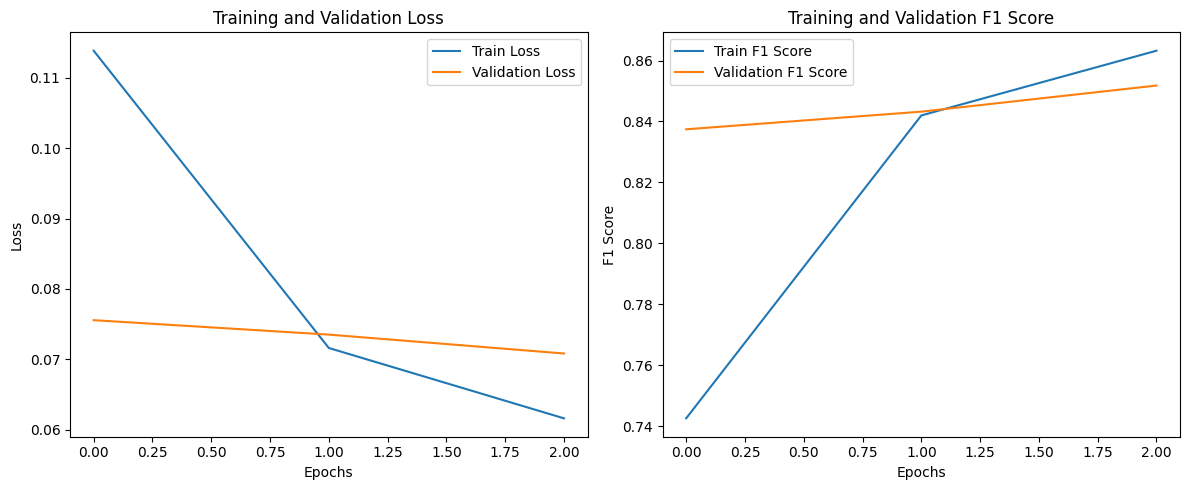

In [ ]:
plot_training_results(train_losses, valid_losses, train_f1_scores, valid_f1_scores)

In [ ]:
predction_base = hybrid_predict_model(model_base, test_loader)

Predicting: 100%|██████████| 625/625 [03:57<00:00,  2.63it/s]


In [ ]:
get_model_size(model_base)

Size of the entire model: 99.86 MB


## Batch Size

 Other Hyper parameter that stay the same when optimizing the Batch Size

In [ ]:
num_epochs = 3
learning_rate = 1e-4

model_batch = EfficientTinyBERTMultiModal(num_labels = 18).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer_batch = torch.optim.Adam(model_batch.parameters(), lr=learning_rate)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Batch Size = 16

In [ ]:
batch_size = 16
train_loader, val_loader = get_train_val_loader(batch_size)
test_loader = get_test_loader(batch_size)

In [ ]:
for epoch in range(num_epochs):
    train_losses, train_f1_scores = hybrid_train_model(model_batch, optimizer_batch, criterion, train_loader, epoch)
    val_losses, val_f1_scores = hybrid_validate_model(model_batch, val_loader, criterion, epoch)

Epoch 1 Training: 100%|██████████| 375/375 [06:05<00:00,  1.03it/s]


Epoch 1, Train Loss: 0.0521, Train F1 Score: 0.8805


Epoch 1 Validation: 100%|██████████| 94/94 [00:43<00:00,  2.15it/s]


Epoch 1, Validation Loss: 0.0699, Validation F1 Score: 0.8542


Epoch 2 Training: 100%|██████████| 375/375 [05:19<00:00,  1.17it/s]


Epoch 2, Train Loss: 0.0461, Train F1 Score: 0.8952


Epoch 2 Validation: 100%|██████████| 94/94 [00:44<00:00,  2.12it/s]


Epoch 2, Validation Loss: 0.0721, Validation F1 Score: 0.8561


Epoch 3 Training: 100%|██████████| 375/375 [05:20<00:00,  1.17it/s]


Epoch 3, Train Loss: 0.0410, Train F1 Score: 0.9061


Epoch 3 Validation: 100%|██████████| 94/94 [00:44<00:00,  2.09it/s]

Epoch 3, Validation Loss: 0.0750, Validation F1 Score: 0.8545


In [ ]:
predction_base = hybrid_predict_model(model_base, test_loader)

Predicting: 100%|██████████| 625/625 [03:57<00:00,  2.63it/s]


In [ ]:
get_model_size(model_base)

Size of the entire model: 99.86 MB


### Batch Size = 32

In [ ]:
batch_size = 32
train_loader, val_loader = get_train_val_loader(batch_size)
test_loader = get_test_loader(batch_size)

In [ ]:
for epoch in range(num_epochs):
    train_losses, train_f1_scores = hybrid_train_model(model_batch, optimizer_batch, criterion, train_loader, epoch)
    val_losses, val_f1_scores = hybrid_validate_model(model_batch, val_loader, criterion, epoch)

Epoch 1 Training: 100%|██████████| 750/750 [07:56<00:00,  1.57it/s]


Epoch 1, Train Loss: 0.1339, Train F1 Score: 0.6911


Epoch 1 Validation: 100%|██████████| 188/188 [01:37<00:00,  1.93it/s]


Epoch 1, Validation Loss: 0.0812, Validation F1 Score: 0.8102


Epoch 2 Training: 100%|██████████| 750/750 [07:59<00:00,  1.56it/s]


Epoch 2, Train Loss: 0.0779, Train F1 Score: 0.8211


Epoch 2 Validation: 100%|██████████| 188/188 [01:27<00:00,  2.14it/s]


Epoch 2, Validation Loss: 0.0729, Validation F1 Score: 0.8384


Epoch 3 Training: 100%|██████████| 750/750 [08:02<00:00,  1.55it/s]


Epoch 3, Train Loss: 0.0653, Train F1 Score: 0.8524


Epoch 3 Validation: 100%|██████████| 188/188 [01:24<00:00,  2.21it/s]

Epoch 3, Validation Loss: 0.0706, Validation F1 Score: 0.8475


In [ ]:
predction_32 = hybrid_predict_model(model_batch, test_loader)

Predicting: 100%|██████████| 313/313 [02:23<00:00,  2.19it/s]


In [ ]:
get_model_size(model_batch)

Size of the entire model: 99.86 MB


### Batch Size = 64

In [ ]:
batch_size = 64
train_loader, val_loader = get_train_val_loader(batch_size)
test_loader = get_test_loader(batch_size)

In [ ]:
train_losses = []
valid_losses = []
train_f1_scores = []
valid_f1_scores = []
# Store data from each epoch for ploting
for epoch in range(num_epochs):
    train_loss, train_f1 = hybrid_train_model(model_base, optimizer_base, criterion, train_loader, epoch)
    valid_loss, valid_f1 = hybrid_validate_model(model_base, val_loader, criterion, epoch)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_f1_scores.append(train_f1)
    valid_f1_scores.append(valid_f1)

Epoch 1 Training:   0%|          | 0/1500 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Epoch 1 Training: 100%|██████████| 1500/1500 [11:43<00:00,  2.13it/s]


Epoch 1, Train Loss: 0.1138, Train F1 Score: 0.7426


Epoch 1 Validation: 100%|██████████| 375/375 [02:21<00:00,  2.66it/s]


Epoch 1, Validation Loss: 0.0756, Validation F1 Score: 0.8374


Epoch 2 Training: 100%|██████████| 1500/1500 [11:46<00:00,  2.12it/s]


Epoch 2, Train Loss: 0.0716, Train F1 Score: 0.8420


Epoch 2 Validation: 100%|██████████| 375/375 [02:23<00:00,  2.61it/s]


Epoch 2, Validation Loss: 0.0735, Validation F1 Score: 0.8432


Epoch 3 Training: 100%|██████████| 1500/1500 [11:51<00:00,  2.11it/s]


Epoch 3, Train Loss: 0.0616, Train F1 Score: 0.8632


Epoch 3 Validation: 100%|██████████| 375/375 [02:23<00:00,  2.61it/s]

Epoch 3, Validation Loss: 0.0708, Validation F1 Score: 0.8518


In [ ]:
predction_64 = hybrid_predict_model(model_batch, test_loader)

Predicting: 100%|██████████| 157/157 [01:14<00:00,  2.10it/s]


In [ ]:
get_model_size(model_batch)

Size of the entire model: 99.86 MB


## Learning Rate

 Other Hyper parameter that stay the same when optimizing the Learning Rate

In [ ]:
num_epochs = 3
batch_size = 16

train_loader, val_loader = get_train_val_loader(batch_size)
test_loader = get_test_loader(batch_size)

model_lr = EfficientTinyBERTMultiModal(num_labels = 18).to(device)
criterion = nn.BCEWithLogitsLoss()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Learning Rate = 0.00001

In [ ]:
learning_rate = 1e-5
optimizer_lr = torch.optim.Adam(model_lr.parameters(), lr=learning_rate)

In [ ]:
for epoch in range(num_epochs):
    train_losses, train_f1_scores = hybrid_train_model(model_lr, optimizer_lr, criterion, train_loader, epoch)
    val_losses, val_f1_scores = hybrid_validate_model(model_lr, val_loader, criterion, epoch)

Epoch 1 Training: 100%|██████████| 375/375 [05:19<00:00,  1.18it/s]


Epoch 1, Train Loss: 0.3321, Train F1 Score: 0.5159


Epoch 1 Validation: 100%|██████████| 94/94 [00:44<00:00,  2.10it/s]


Epoch 1, Validation Loss: 0.1924, Validation F1 Score: 0.5968


Epoch 2 Training: 100%|██████████| 375/375 [05:19<00:00,  1.17it/s]


Epoch 2, Train Loss: 0.1775, Train F1 Score: 0.5895


Epoch 2 Validation: 100%|██████████| 94/94 [00:43<00:00,  2.18it/s]


Epoch 2, Validation Loss: 0.1599, Validation F1 Score: 0.6073


Epoch 3 Training: 100%|██████████| 375/375 [05:16<00:00,  1.18it/s]


Epoch 3, Train Loss: 0.1483, Train F1 Score: 0.6045


Epoch 3 Validation: 100%|██████████| 94/94 [00:43<00:00,  2.16it/s]

Epoch 3, Validation Loss: 0.1338, Validation F1 Score: 0.6304


In [ ]:
predction_00001 = hybrid_predict_model(model_lr, test_loader)

Predicting: 100%|██████████| 157/157 [01:20<00:00,  1.96it/s]


In [ ]:
get_model_size(model_lr)

Size of the entire model: 99.86 MB


### Learning Rate = 0.0001

In [ ]:
learning_rate = 1e-4
optimizer_lr = torch.optim.Adam(model_lr.parameters(), lr=learning_rate)

In [ ]:
for epoch in range(num_epochs):
    train_losses, train_f1_scores = hybrid_train_model(model_batch, optimizer_batch, criterion, train_loader, epoch)
    val_losses, val_f1_scores = hybrid_validate_model(model_batch, val_loader, criterion, epoch)

Epoch 1 Training: 100%|██████████| 375/375 [06:05<00:00,  1.03it/s]


Epoch 1, Train Loss: 0.0521, Train F1 Score: 0.8805


Epoch 1 Validation: 100%|██████████| 94/94 [00:43<00:00,  2.15it/s]


Epoch 1, Validation Loss: 0.0699, Validation F1 Score: 0.8542


Epoch 2 Training: 100%|██████████| 375/375 [05:19<00:00,  1.17it/s]


Epoch 2, Train Loss: 0.0461, Train F1 Score: 0.8952


Epoch 2 Validation: 100%|██████████| 94/94 [00:44<00:00,  2.12it/s]


Epoch 2, Validation Loss: 0.0721, Validation F1 Score: 0.8561


Epoch 3 Training: 100%|██████████| 375/375 [05:20<00:00,  1.17it/s]


Epoch 3, Train Loss: 0.0410, Train F1 Score: 0.9061


Epoch 3 Validation: 100%|██████████| 94/94 [00:44<00:00,  2.09it/s]

Epoch 3, Validation Loss: 0.0750, Validation F1 Score: 0.8545


In [ ]:
predction_0001 = hybrid_predict_model(model_batch, test_loader)

Predicting: 100%|██████████| 157/157 [01:14<00:00,  2.10it/s]


In [ ]:
get_model_size(model_batch)

Size of the entire model: 99.86 MB


### Learning Rate = 0.001

In [ ]:
learning_rate = 1e-3
optimizer_lr = torch.optim.Adam(model_lr.parameters(), lr=learning_rate)

In [ ]:
for epoch in range(num_epochs):
    train_losses, train_f1_scores = hybrid_train_model(model_lr, optimizer_lr, criterion, train_loader, epoch)
    val_losses, val_f1_scores = hybrid_validate_model(model_lr, val_loader, criterion, epoch)

Epoch 1 Training: 100%|██████████| 375/375 [05:17<00:00,  1.18it/s]


Epoch 1, Train Loss: 0.1128, Train F1 Score: 0.7279


Epoch 1 Validation: 100%|██████████| 94/94 [00:45<00:00,  2.09it/s]


Epoch 1, Validation Loss: 0.1020, Validation F1 Score: 0.7665


Epoch 2 Training: 100%|██████████| 375/375 [05:20<00:00,  1.17it/s]


Epoch 2, Train Loss: 0.0926, Train F1 Score: 0.7810


Epoch 2 Validation: 100%|██████████| 94/94 [00:43<00:00,  2.15it/s]


Epoch 2, Validation Loss: 0.0982, Validation F1 Score: 0.7719


Epoch 3 Training: 100%|██████████| 375/375 [05:18<00:00,  1.18it/s]


Epoch 3, Train Loss: 0.0808, Train F1 Score: 0.8099


Epoch 3 Validation: 100%|██████████| 94/94 [00:44<00:00,  2.10it/s]

Epoch 3, Validation Loss: 0.0973, Validation F1 Score: 0.7846


In [ ]:
predction_001 = hybrid_predict_model(model_lr, test_loader)

Predicting: 100%|██████████| 157/157 [01:14<00:00,  2.10it/s]


In [ ]:
get_model_size(model_lr)

Size of the entire model: 99.86 MB


## Epoch

 Other Hyper parameter that stay the same when optimizing the Learning Rate

In [ ]:
batch_size = 16

train_loader, val_loader = get_train_val_loader(batch_size)
test_loader = get_test_loader(batch_size)

model_epoch = EfficientTinyBERTMultiModal(num_labels = 18).to(device)
criterion = nn.BCEWithLogitsLoss()
learning_rate = 1e-4
optimizer_epoch = torch.optim.Adam(model_epoch.parameters(), lr=learning_rate)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 138MB/s]
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab sec

config.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/62.7M [00:00<?, ?B/s]

### Epoch = 4

In [ ]:
num_epochs = 4

In [ ]:
for epoch in range(num_epochs):
    train_losses, train_f1_scores = hybrid_train_model(model_epoch, optimizer_epoch, criterion, train_loader, epoch)
    val_losses, val_f1_scores = hybrid_validate_model(model_epoch, val_loader, criterion, epoch)

Epoch 1 Training:   0%|          | 0/375 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Epoch 1 Training: 100%|██████████| 375/375 [05:24<00:00,  1.15it/s]


Epoch 1, Train Loss: 0.1578, Train F1 Score: 0.6529


Epoch 1 Validation: 100%|██████████| 94/94 [00:44<00:00,  2.10it/s]


Epoch 1, Validation Loss: 0.0877, Validation F1 Score: 0.8025


Epoch 2 Training: 100%|██████████| 375/375 [05:24<00:00,  1.16it/s]


Epoch 2, Train Loss: 0.0793, Train F1 Score: 0.8171


Epoch 2 Validation: 100%|██████████| 94/94 [00:44<00:00,  2.11it/s]


Epoch 2, Validation Loss: 0.0731, Validation F1 Score: 0.8404


Epoch 3 Training: 100%|██████████| 375/375 [05:19<00:00,  1.17it/s]


Epoch 3, Train Loss: 0.0657, Train F1 Score: 0.8521


Epoch 3 Validation: 100%|██████████| 94/94 [00:44<00:00,  2.10it/s]


Epoch 3, Validation Loss: 0.0690, Validation F1 Score: 0.8481


Epoch 4 Training: 100%|██████████| 375/375 [05:34<00:00,  1.12it/s]


Epoch 4, Train Loss: 0.0571, Train F1 Score: 0.8703


Epoch 4 Validation: 100%|██████████| 94/94 [00:47<00:00,  1.97it/s]

Epoch 4, Validation Loss: 0.0694, Validation F1 Score: 0.8523


In [ ]:
predction_4 = hybrid_predict_model(model_epoch, test_loader)

Predicting: 100%|██████████| 157/157 [01:15<00:00,  2.08it/s]


In [ ]:
get_model_size(model_epoch)

Size of the entire model: 99.86 MB


### Epoch = 3

In [ ]:
num_epochs = 3

In [ ]:
for epoch in range(num_epochs):
    train_losses, train_f1_scores = hybrid_train_model(model_batch, optimizer_batch, criterion, train_loader, epoch)
    val_losses, val_f1_scores = hybrid_validate_model(model_batch, val_loader, criterion, epoch)

Epoch 1 Training: 100%|██████████| 375/375 [06:05<00:00,  1.03it/s]


Epoch 1, Train Loss: 0.0521, Train F1 Score: 0.8805


Epoch 1 Validation: 100%|██████████| 94/94 [00:43<00:00,  2.15it/s]


Epoch 1, Validation Loss: 0.0699, Validation F1 Score: 0.8542


Epoch 2 Training: 100%|██████████| 375/375 [05:19<00:00,  1.17it/s]


Epoch 2, Train Loss: 0.0461, Train F1 Score: 0.8952


Epoch 2 Validation: 100%|██████████| 94/94 [00:44<00:00,  2.12it/s]


Epoch 2, Validation Loss: 0.0721, Validation F1 Score: 0.8561


Epoch 3 Training: 100%|██████████| 375/375 [05:20<00:00,  1.17it/s]


Epoch 3, Train Loss: 0.0410, Train F1 Score: 0.9061


Epoch 3 Validation: 100%|██████████| 94/94 [00:44<00:00,  2.09it/s]

Epoch 3, Validation Loss: 0.0750, Validation F1 Score: 0.8545


In [ ]:
predction_3 = hybrid_predict_model(model_batch, test_loader)

Predicting: 100%|██████████| 157/157 [01:14<00:00,  2.10it/s]


In [ ]:
get_model_size(model_epoch)

Size of the entire model: 99.86 MB


### Epoch = 2

In [ ]:
num_epochs = 2

In [ ]:
for epoch in range(num_epochs):
    train_losses, train_f1_scores = hybrid_train_model(model_epoch, optimizer_epoch, criterion, train_loader, epoch)
    val_losses, val_f1_scores = hybrid_validate_model(model_epoch, val_loader, criterion, epoch)

Epoch 1 Training: 100%|██████████| 375/375 [05:13<00:00,  1.20it/s]


Epoch 1, Train Loss: 0.0492, Train F1 Score: 0.8886


Epoch 1 Validation: 100%|██████████| 94/94 [00:43<00:00,  2.18it/s]


Epoch 1, Validation Loss: 0.0708, Validation F1 Score: 0.8557


Epoch 2 Training: 100%|██████████| 375/375 [05:15<00:00,  1.19it/s]


Epoch 2, Train Loss: 0.0419, Train F1 Score: 0.9046


Epoch 2 Validation: 100%|██████████| 94/94 [00:43<00:00,  2.14it/s]

Epoch 2, Validation Loss: 0.0748, Validation F1 Score: 0.8524


In [ ]:
predction_2 = hybrid_predict_model(model_epoch, test_loader)

Predicting: 100%|██████████| 157/157 [01:14<00:00,  2.10it/s]


In [ ]:
get_model_size(model_epoch)

Size of the entire model: 99.86 MB


# Ablation Experiment

In [ ]:
num_epochs = 3
learning_rate = 1e-4
batch_size = 16

train_loader, val_loader = get_train_val_loader(batch_size)
test_loader = get_test_loader(batch_size)
criterion = nn.BCEWithLogitsLoss()


## EfficientNet b3 Only

In [ ]:
model_efficientnetb3 = EfficientNet.from_pretrained('efficientnet-b3')
num_ftrs = model_efficientnetb3._fc.in_features
model_efficientnetb3._fc = nn.Linear(num_ftrs, num_labels)
model_efficientnetb3 = model_efficientnetb3.to(device)
optimizer_efficientnetb3 = optim.Adam(model_efficientnetb3.parameters(), lr=0.0001)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth
100%|██████████| 47.1M/47.1M [00:00<00:00, 318MB/s]


Loaded pretrained weights for efficientnet-b3


In [ ]:
for epoch in range(num_epochs):
    train_model(model_efficientnetb3, optimizer_efficientnetb3, loss_function, train_loader, epoch)
    validate_model(model_efficientnetb3, val_loader, loss_function, epoch)

Epoch 1 Training: 100%|██████████| 375/375 [05:58<00:00,  1.05it/s]


Epoch 1, Train Loss: 0.20219264103968937, Train F1 Score: 0.5979844892004942, Epoch Time: 358.63 seconds


Epoch 1 Validation: 100%|██████████| 94/94 [00:37<00:00,  2.52it/s]


Epoch 1, Validation Loss: 0.11431621839391425, Validation F1 Score: 0.7406203101550776, Validation Time: 37.31 seconds


Epoch 2 Training: 100%|██████████| 375/375 [05:58<00:00,  1.05it/s]


Epoch 2, Train Loss: 0.1024839024146398, Train F1 Score: 0.7743681761503602, Epoch Time: 358.25 seconds


Epoch 2 Validation: 100%|██████████| 94/94 [00:37<00:00,  2.53it/s]


Epoch 2, Validation Loss: 0.09377598762512207, Validation F1 Score: 0.7993344821439182, Validation Time: 37.20 seconds


Epoch 3 Training: 100%|██████████| 375/375 [05:57<00:00,  1.05it/s]


Epoch 3, Train Loss: 0.08349734127521515, Train F1 Score: 0.818615787062353, Epoch Time: 357.93 seconds


Epoch 3 Validation: 100%|██████████| 94/94 [00:37<00:00,  2.53it/s]

Epoch 3, Validation Loss: 0.08740154951018222, Validation F1 Score: 0.8146014577944979, Validation Time: 37.12 seconds


In [ ]:
predict_results = predict_model(model_efficientnetb3, test_loader)

Predicting: 100%|██████████| 157/157 [01:01<00:00,  2.54it/s]


Predict Time: 61.74 seconds


In [ ]:
get_model_size(model_efficientnetb3)

Size of the entire model: 41.50 MB


## Tiny Bert Only

In [ ]:
class MultilabelTinyBERT(torch.nn.Module):
    def __init__(self, num_labels):
        super(MultilabelTinyBERT, self).__init__()
        config = AutoConfig.from_pretrained('huawei-noah/TinyBERT_General_4L_312D')
        self.tinybert = AutoModel.from_pretrained('huawei-noah/TinyBERT_General_4L_312D', config=config)
        self.classifier = torch.nn.Linear(config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.tinybert(input_ids=input_ids, attention_mask=attention_mask)
        logits = self.classifier(outputs.pooler_output)
        return torch.sigmoid(logits)

In [ ]:
model_bert = MultilabelTinyBERT(num_labels=18)
model_bert.to(device)
optimizer_bert = optim.Adam(model_bert.parameters(), lr=0.0001)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
for epoch in range(num_epochs):
    text_train_model(model_bert, optimizer_bert, loss_function, train_loader, epoch)
    text_validate_model(model_bert, val_loader, loss_function, epoch)

Epoch 1 Training: 100%|██████████| 375/375 [02:13<00:00,  2.81it/s]


Epoch 1, Train Loss: 0.7087813636461894, Train F1 Score: 0.15872555748334263, Epoch Time: 133.41 seconds


Epoch 1 Validation: 100%|██████████| 94/94 [00:32<00:00,  2.93it/s]


Epoch 1, Validation Loss: 0.6872488843633774, Validation F1 Score: 0.15847357921121286, Validation Time: 32.09 seconds


Epoch 2 Training: 100%|██████████| 375/375 [02:12<00:00,  2.84it/s]


Epoch 2, Train Loss: 0.6860635687510173, Train F1 Score: 0.15872555748334263, Epoch Time: 132.13 seconds


Epoch 2 Validation: 100%|██████████| 94/94 [00:32<00:00,  2.85it/s]


Epoch 2, Validation Loss: 0.6863465632529969, Validation F1 Score: 0.15847357921121286, Validation Time: 33.00 seconds


Epoch 3 Training: 100%|██████████| 375/375 [02:13<00:00,  2.82it/s]


Epoch 3, Train Loss: 0.6855974435806275, Train F1 Score: 0.15872555748334263, Epoch Time: 133.16 seconds


Epoch 3 Validation: 100%|██████████| 94/94 [00:32<00:00,  2.86it/s]

Epoch 3, Validation Loss: 0.6861217903329971, Validation F1 Score: 0.15847357921121286, Validation Time: 32.84 seconds


In [ ]:
predict_results = text_predict_model(model_bert, tokenizer, test_loader)

100%|██████████| 157/157 [00:29<00:00,  5.30it/s]


In [ ]:
get_model_size(model_bert)

Size of the entire model: 54.82 MB


# BestModel-EfficientTinyBERTMultiModal

In [ ]:
class EfficientTinyBERTMultiModal(nn.Module):
    def __init__(self, num_labels):
        super(EfficientTinyBERTMultiModal, self).__init__()

        # Load EfficientNet-B3
        self.efficientnet = models.efficientnet_b3(pretrained=True)
        num_ftrs = self.efficientnet.classifier[1].in_features
        self.efficientnet.classifier = nn.Identity()
        # We do not use the classifier layer

        # Load TinyBERT from Huawei Noah
        config = AutoConfig.from_pretrained('huawei-noah/TinyBERT_General_4L_312D')
        self.tinybert = AutoModel.from_pretrained('huawei-noah/TinyBERT_General_4L_312D', config=config)

        # Classifier combining features from EfficientNet and TinyBERT
        self.classifier = nn.Sequential(
            nn.Linear(num_ftrs + config.hidden_size, 512),  # Combining features from both models
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, num_labels)
        )

    def forward(self, image, input_ids, attention_mask):
        # Process image through EfficientNet
        image_features = self.efficientnet(image)

        # Process text through TinyBERT
        text_outputs = self.tinybert(input_ids=input_ids, attention_mask=attention_mask)
        text_features = text_outputs.last_hidden_state[:, 0, :]  # Take the output of the [CLS] token

        # Concatenate features from both models
        combined_features = torch.cat((image_features, text_features), dim=1)
        return self.classifier(combined_features)

In [ ]:
num_epochs = 3
batch_size = 16
learning_rate = 1e-4

train_all_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
train_loader, val_loader = get_train_val_loader(batch_size)
test_loader = get_test_loader(batch_size)

In [ ]:
model_base = EfficientTinyBERTMultiModal(num_labels = 18).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer_base = torch.optim.Adam(model_base.parameters(), lr=learning_rate)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
train_losses = []
valid_losses = []
train_f1_scores = []
valid_f1_scores = []

for epoch in range(num_epochs):
    train_loss, train_f1 = hybrid_train_model(model_base, optimizer_base, criterion, train_all_loader, epoch)
    valid_loss, valid_f1 = hybrid_validate_model(model_base, val_loader, criterion, epoch)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_f1_scores.append(train_f1)
    valid_f1_scores.append(valid_f1)

Epoch 1 Training: 100%|██████████| 1875/1875 [09:48<00:00,  3.19it/s]


Epoch 1, Train Loss: 0.1091, Train F1 Score: 0.7482


Epoch 1 Validation: 100%|██████████| 375/375 [01:22<00:00,  4.52it/s]


Epoch 1, Validation Loss: 0.0651, Validation F1 Score: 0.8503


Epoch 2 Training: 100%|██████████| 1875/1875 [09:46<00:00,  3.19it/s]


Epoch 2, Train Loss: 0.0711, Train F1 Score: 0.8441


Epoch 2 Validation: 100%|██████████| 375/375 [01:24<00:00,  4.46it/s]


Epoch 2, Validation Loss: 0.0539, Validation F1 Score: 0.8752


Epoch 3 Training: 100%|██████████| 1875/1875 [09:48<00:00,  3.19it/s]


Epoch 3, Train Loss: 0.0611, Train F1 Score: 0.8636


Epoch 3 Validation: 100%|██████████| 375/375 [01:22<00:00,  4.57it/s]

Epoch 3, Validation Loss: 0.0439, Validation F1 Score: 0.8966


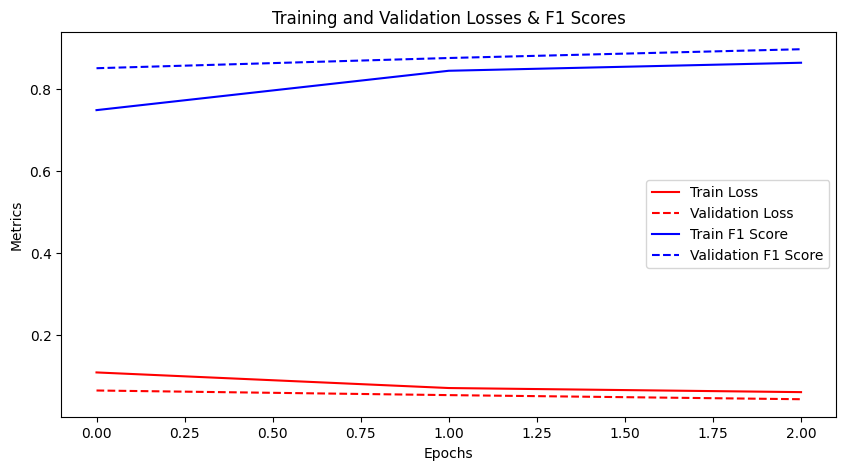

In [ ]:
plot_training_results(train_losses, valid_losses, train_f1_scores, valid_f1_scores)

In [ ]:
predction_base = hybrid_predict_model(model_base, test_loader)

Predicting: 100%|██████████| 625/625 [02:17<00:00,  4.54it/s]


In [ ]:
get_model_size(model_base)

Size of the entire model: 99.86 MB
